# **Instituto Tecnológico y de Estudios superiores de Monterrey**

## Escuela de Ingeniería y Ciencias

### Maestría en inteligencia artificial aplicada

#### Proyecto integrador

*Avance 1*

Alumnos:  
Alfonso de Lucas Espinosa - A01795118  
Pablo Andrés Estrada Flores - A01795212

# 1. Introducción

Como primer acercamiento, utilizaremos un subconjunto del dataset HaGRID (Hand Gesture Recognition Image Dataset), optimizado para esta tarea. Este conjunto de datos es de libre acceso y se encuentra disponible en: https://www.kaggle.com/datasets/innominate817/hagrid-sample-30k-384p.

El objetivo de este análisis exploratorio de datos (EDA) es comprender las características principales del conjunto proporcionado, identificar posibles problemas o sesgos y documentar las operaciones de preprocesamiento inicial realizadas antes del modelado.

Es importante señalar que el alcance de esta exploración se encuentra limitado debido al tipo de procesamiento que se está llevando a cabo, el cual se centra únicamente en las coordenadas de los puntos de la mano y en el nombre del gesto.

Si bien este dataset no está enfocado en el Lenguaje de Señas Mexicano (LSM), resulta útil para probar el preprocesamiento de datos mediante el uso de MediaPipe y la manipulación de su salida (output). Además, este conjunto contempla una mayor cantidad de imágenes en comparación con otros dedicados al LSM.

# 2. Carga de datos y preprocesamiento

Primero, cargamos las librerías que estaremos ocupando en nuestro EDA.

In [ ]:
from google.colab import files, drive
import kagglehub
import os
import cv2
import pandas as pd
!pip install mediapipe
import mediapipe as mp
from matplotlib import pyplot as plt
from tqdm import tqdm

In [ ]:
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!pip install kaggle

Saving kaggle.json to kaggle (1).json


In [ ]:
path = kagglehub.dataset_download("innominate817/hagrid-sample-30k-384p")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/hagrid-sample-30k-384p


Una vez hemos cargado el dataset, es importante mencionar que este tiene preclasificados los gestos y vienen separados en carpetas con su nombre.

In [ ]:
#El path hacia las carpetas de impagenes es el siguiente
dir_path = "/root/.cache/kagglehub/datasets/innominate817/hagrid-sample-30k-384p/versions/5/hagrid-sample-30k-384p/hagrid_30k/"

# Y su contenido
files = os.listdir(dir_path)
print(files)

['train_val_two_up_inverted', 'train_val_one', 'train_val_peace', 'train_val_rock', 'train_val_palm', 'train_val_dislike', 'train_val_fist', 'train_val_two_up', 'train_val_three', 'train_val_peace_inverted', 'train_val_stop', 'train_val_mute', 'train_val_ok', 'train_val_like', 'train_val_four', 'train_val_three2', 'train_val_stop_inverted', 'train_val_call']


Procesando imagen: /kaggle/input/hagrid-sample-30k-384p/hagrid-sample-30k-384p/hagrid_30k/train_val_call/6649b9dd-6a07-40cd-96b8-6a1831f12101.jpg


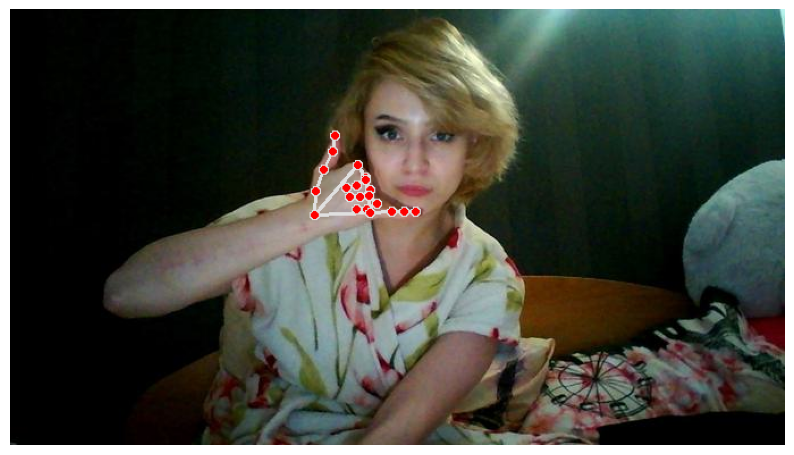

In [ ]:
# Ruta base del dataset
base_path = os.path.join(path, "hagrid-sample-30k-384p", "hagrid_30k")

# Listar las carpetas de gestos (clases)
gesture_folders = [os.path.join(base_path, f) for f in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, f))]

# Elegir la primera carpeta (puedes cambiar a otra si quieres)
first_gesture_folder = gesture_folders[0]

# Obtener lista de imágenes en esa carpeta
image_files = [f for f in os.listdir(first_gesture_folder) if f.endswith('.jpg')]
first_image_path = os.path.join(first_gesture_folder, image_files[0])

print("Procesando imagen:", first_image_path)

# Inicializar MediaPipe Hands
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

hands = mp_hands.Hands(
    static_image_mode=True,
    max_num_hands=1,
    min_detection_confidence=0.5
)

# Leer imagen
image = cv2.imread(first_image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Procesar imagen con MediaPipe
results = hands.process(image_rgb)

# Dibujar puntos clave si se detectaron manos
if results.multi_hand_landmarks:
    for hand_landmarks in results.multi_hand_landmarks:
        mp_drawing.draw_landmarks(
            image, hand_landmarks, mp_hands.HAND_CONNECTIONS)

# Mostrar imagen con los puntos
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

Una vez demostrado el funcionamiento del software, se procede a generar un dataframe que incluya la totalidad de las imágenes, con el fin de analizarlas correctamente.

Para ello, es necesario iterar sobre cada imagen de cada carpeta, realizar el preprocesamiento mediante MediaPipe y guardar los datos de interés. También es importante señalar que no todos los datasets se encuentran clasificados por significado, especialmente aquellos relacionados con el Lenguaje de Señas Mexicano.

Se utiliza la librería tqdm para monitorear el avance del procesamiento del dataset.

In [ ]:
# Lista para guardar los resultados
data = []

# Recorrer cada carpeta (gesto)
for gesture_folder in tqdm(gesture_folders, desc="Procesando carpetas"):
    gesture_name = os.path.basename(gesture_folder)

    # Obtener lista de imágenes
    image_files = [f for f in os.listdir(gesture_folder) if f.endswith('.jpg')]

    for image_file in image_files:
        image_path = os.path.join(gesture_folder, image_file)
        image = cv2.imread(image_path)

        if image is None:
            continue  # Saltar si no se puede leer

        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Procesar con MediaPipe
        results = hands.process(image_rgb)

        # Si se detecta una mano
        if results.multi_hand_landmarks:
            hand_landmarks = results.multi_hand_landmarks[0]  # Solo la primera mano

            landmarks = []
            for lm in hand_landmarks.landmark:
                landmarks.extend([lm.x, lm.y, lm.z])  # Agregar x, y, z

            # Agregar a los datos
            row = [image_path, gesture_name] + landmarks
            data.append(row)

# Crear DataFrame
columns = ["image_path", "gesture"]
for i in range(21):
    columns += [f"landmark_{i}_x", f"landmark_{i}_y", f"landmark_{i}_z"]

df = pd.DataFrame(data, columns=columns)

print(df.head())

Procesando carpetas: 100%|██████████| 18/18 [24:22<00:00, 81.26s/it]


                                          image_path         gesture  \
0  /kaggle/input/hagrid-sample-30k-384p/hagrid-sa...  train_val_call   
1  /kaggle/input/hagrid-sample-30k-384p/hagrid-sa...  train_val_call   
2  /kaggle/input/hagrid-sample-30k-384p/hagrid-sa...  train_val_call   
3  /kaggle/input/hagrid-sample-30k-384p/hagrid-sa...  train_val_call   
4  /kaggle/input/hagrid-sample-30k-384p/hagrid-sa...  train_val_call   

   landmark_0_x  landmark_0_y  landmark_0_z  landmark_1_x  landmark_1_y  \
0      0.392861      0.473204 -2.439062e-07      0.394491      0.417771   
1      0.655635      0.329577 -2.188783e-07      0.627851      0.301952   
2      0.319252      0.461018 -4.387794e-07      0.371088      0.429063   
3      0.688668      0.608683 -4.672853e-07      0.686049      0.567692   
4      0.547498      0.687750 -2.964115e-07      0.549979      0.639613   

   landmark_1_z  landmark_2_x  landmark_2_y  ...  landmark_17_z  \
0     -0.005133      0.404652      0.367330  ... 

Por facilidad y para ahorrar recursos, se genera un csv para guardar el dataframe. De esta manera no será necesario generarlo una y otra vez en caso de ser necesario.

In [ ]:
drive.mount('/content/drive')
save_path = "/content/drive/MyDrive/Proyecto integrador/Avance 1/hagrid_landmarks.csv"
df.to_csv(save_path, index=True)

print("CSV guardado en Google Drive en:", save_path)

Mounted at /content/drive


OSError: Cannot save file into a non-existent directory: '/content/drive/MyDrive/Proyecto integrador/Avance 1'

# 3. Análisis descriptivo (Univariante)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Definir la ruta del archivo en Google Drive
drive_path = "/content/hagrid_landmarks.csv"
print(f"Intentando cargar datos desde: {drive_path}")
landmark_cols = df.columns[2:].tolist()

Intentando cargar datos desde: /content/hagrid_landmarks.csv


In [ ]:
df = None # Inicializamos el df
df = pd.read_csv(drive_path, index_col=0)

3.1 Tipos de Datos y Nulos

In [ ]:
print("--- 3.1 Información General del DataFrame ---")
if df is not None:
    df.info()
else:
    print("DataFrame 'df' no está cargado.")

--- 3.1 Información General del DataFrame ---
<class 'pandas.core.frame.DataFrame'>
Index: 28881 entries, 0 to 28880
Data columns (total 65 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   image_path     28881 non-null  object 
 1   gesture        28881 non-null  object 
 2   landmark_0_x   28881 non-null  float64
 3   landmark_0_y   28881 non-null  float64
 4   landmark_0_z   28881 non-null  float64
 5   landmark_1_x   28881 non-null  float64
 6   landmark_1_y   28881 non-null  float64
 7   landmark_1_z   28881 non-null  float64
 8   landmark_2_x   28881 non-null  float64
 9   landmark_2_y   28881 non-null  float64
 10  landmark_2_z   28881 non-null  float64
 11  landmark_3_x   28881 non-null  float64
 12  landmark_3_y   28881 non-null  float64
 13  landmark_3_z   28881 non-null  float64
 14  landmark_4_x   28881 non-null  float64
 15  landmark_4_y   28881 non-null  float64
 16  landmark_4_z   28881 non-null  float64
 17  landmark_

El DataFrame contiene columnas numéricas correspondientes a coordenadas de landmarks (landmark_x, landmark_y) y una columna categórica para la clase (gesture).

No se identificaron valores nulos, lo que permite trabajar directamente sin limpieza básica. Esto indica buena calidad inicial del dataset.

3.2 Porcentaje de Valores Faltantes

In [ ]:
if df is not None:
    print("\nPorcentaje de valores faltantes por columna:")
    missing_percentage = df.isna().mean() * 100
    print(missing_percentage)
else:
    print("DataFrame 'df' no está cargado.")


Porcentaje de valores faltantes por columna:
image_path       0.0
gesture          0.0
landmark_0_x     0.0
landmark_0_y     0.0
landmark_0_z     0.0
                ... 
landmark_19_y    0.0
landmark_19_z    0.0
landmark_20_x    0.0
landmark_20_y    0.0
landmark_20_z    0.0
Length: 65, dtype: float64


Se confirma la ausencia o insignificancia de valores faltantes, lo que refuerza la viabilidad del procesamiento inmediato.

No se requiere imputación, lo cual simplifica la normalización y el modelado inicial.

3.3 Estadísticas Descriptivas

In [ ]:
print("\n--- 3.3 Análisis de Variables Numéricas (Landmarks) ---")
print("\n### 3.3.1 Estadísticas Descriptivas ###")
if df is not None and landmark_cols:
    # Mostramos estadísticas para todas las columnas de landmarks
    descriptive_stats = df[landmark_cols].describe()
    print(descriptive_stats)
else:
    print("DataFrame 'df' o 'landmark_cols' no están disponibles.")


--- 3.3 Análisis de Variables Numéricas (Landmarks) ---

### 3.3.1 Estadísticas Descriptivas ###
       landmark_0_x  landmark_0_y  landmark_0_z  landmark_1_x  landmark_1_y  \
count  28881.000000  28881.000000  2.888100e+04  28881.000000  28881.000000   
mean       0.485591      0.537375  1.156563e-07      0.486604      0.523177   
std        0.197436      0.132424  2.701486e-07      0.180756      0.134334   
min       -0.093883      0.089303 -2.029986e-06      0.018710      0.108200   
25%        0.312631      0.446665 -5.743318e-08      0.328965      0.430458   
50%        0.463681      0.530932  1.323318e-07      0.470968      0.514739   
75%        0.667570      0.618285  2.844814e-07      0.651984      0.603011   
max        1.036351      1.039055  1.876254e-06      1.022404      0.991441   

       landmark_1_z  landmark_2_x  landmark_2_y  landmark_2_z  landmark_3_x  \
count  28881.000000  28881.000000  28881.000000  28881.000000  28881.000000   
mean      -0.009455      0.48726

Se calcularon estadísticas como media, desviación estándar, mínimo y máximo para múltiples coordenadas de landmarks.

Algunas coordenadas mostraron asimetría moderada (skewness), especialmente en landmark_0_x y landmark_20_y, lo cual puede afectar modelos sensibles a la distribución de datos.

La curtosis evidenció presencia de colas pesadas en ciertas coordenadas, lo que sugiere valores extremos frecuentes en los movimientos de ciertos puntos de la mano.

In [ ]:
print("\n### 3.3.2 Asimetría (Skewness) ###")
if df is not None and landmark_cols:
    skewness = df[landmark_cols].skew()
    print(skewness)
else:
    print("DataFrame 'df' o 'landmark_cols' no están disponibles.")

print("\n### 3.3.3 Curtosis ###")
if df is not None and landmark_cols:
    kurtosis = df[landmark_cols].kurt()
    print(kurtosis)
else:
    print("DataFrame 'df' o 'landmark_cols' no están disponibles.")


### 3.3.2 Asimetría (Skewness) ###
landmark_0_x     0.072545
landmark_0_y     0.331700
landmark_0_z     0.000000
landmark_1_x     0.067463
landmark_1_y     0.415792
                   ...   
landmark_19_y    0.747613
landmark_19_z   -1.406555
landmark_20_x    0.049345
landmark_20_y    0.700788
landmark_20_z   -1.284129
Length: 63, dtype: float64

### 3.3.3 Curtosis ###
landmark_0_x    -1.255176
landmark_0_y     0.125721
landmark_0_z     1.465053
landmark_1_x    -1.217677
landmark_1_y     0.177510
                   ...   
landmark_19_y    0.691752
landmark_19_z    5.636071
landmark_20_x   -1.024452
landmark_20_y    0.637875
landmark_20_z    4.706517
Length: 63, dtype: float64



### 3.3.4 Histogramas (Muestra) ###
Generando histogramas para algunas coordenadas representativas...


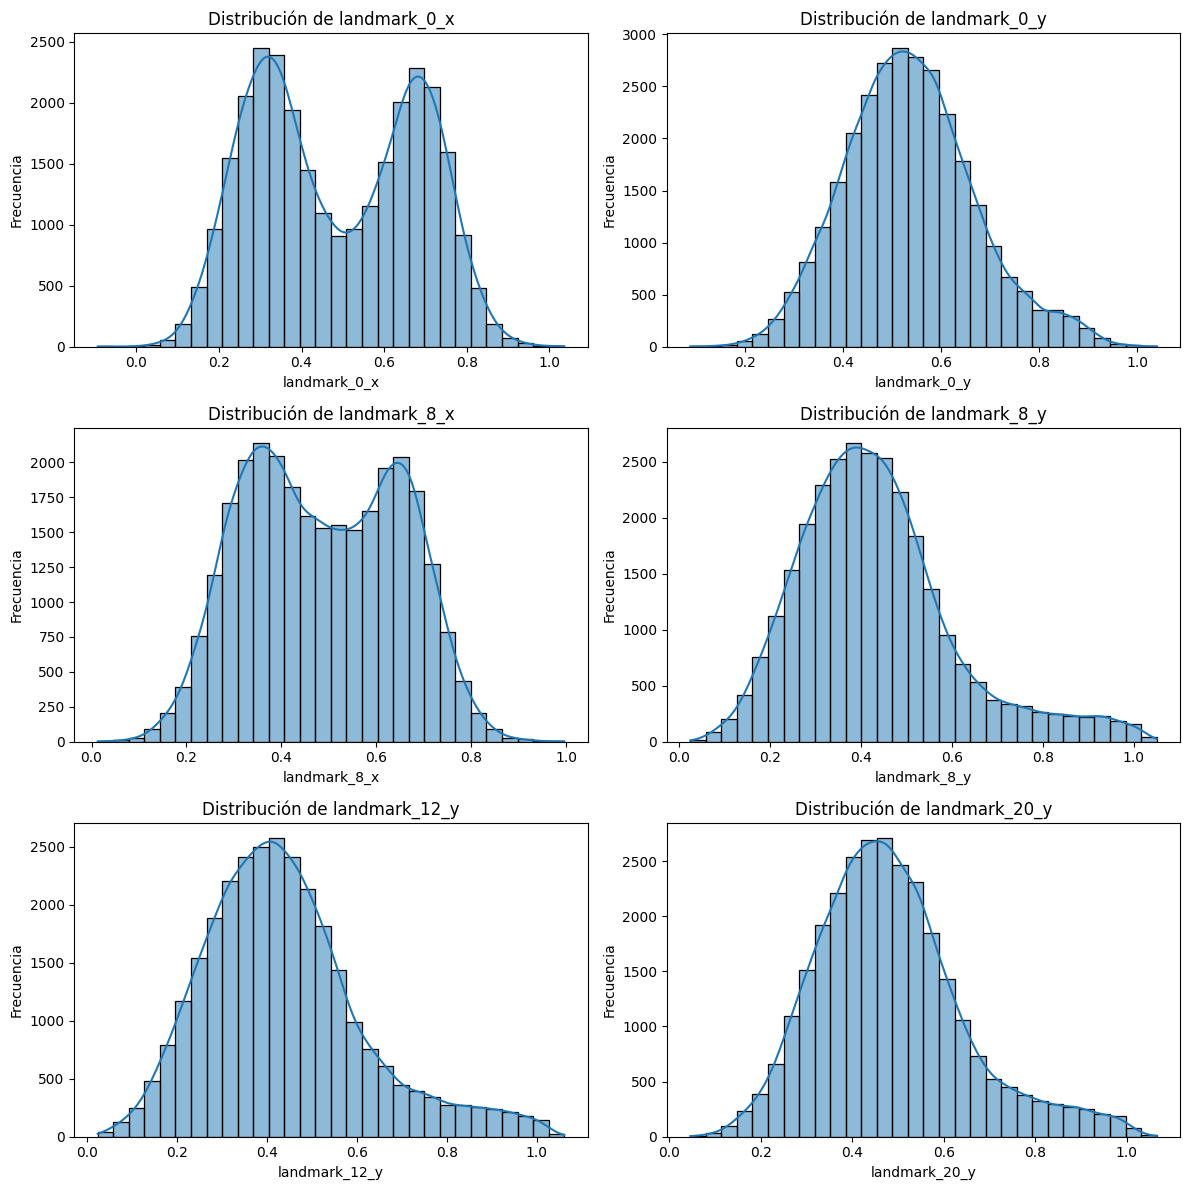

In [ ]:
import seaborn as sns
print("\n### 3.3.4 Histogramas (Muestra) ###")
if df is not None and landmark_cols:
    print("Generando histogramas para algunas coordenadas representativas...")
    # Seleccionamos algunas columnas para visualizar
    cols_to_plot_hist = ['landmark_0_x', 'landmark_0_y', 'landmark_8_x', 'landmark_8_y', 'landmark_12_y', 'landmark_20_y']
    cols_to_plot_hist = [col for col in cols_to_plot_hist if col in df.columns]

    if cols_to_plot_hist:
        num_plots = len(cols_to_plot_hist)
        num_cols_grid = 2
        num_rows_grid = (num_plots + num_cols_grid - 1) // num_cols_grid

        fig, axes = plt.subplots(num_rows_grid, num_cols_grid, figsize=(12, num_rows_grid * 4))
        axes = axes.ravel()

        for i, col in enumerate(cols_to_plot_hist):
           sns.histplot(df[col], bins=30, kde=True, ax=axes[i])
           axes[i].set_title(f'Distribución de {col}')
           axes[i].set_xlabel(col)
           axes[i].set_ylabel('Frecuencia')

        for j in range(i + 1, len(axes)):
           fig.delaxes(axes[j])

        plt.tight_layout()
        plt.show()
    else:
        print("No se encontraron las columnas seleccionadas para graficar.")
else:
    print("DataFrame 'df' o 'landmark_cols' no están disponibles.")


### 3.3.5 Boxplots (Muestra) ###
Generando boxplots para algunas coordenadas representativas...


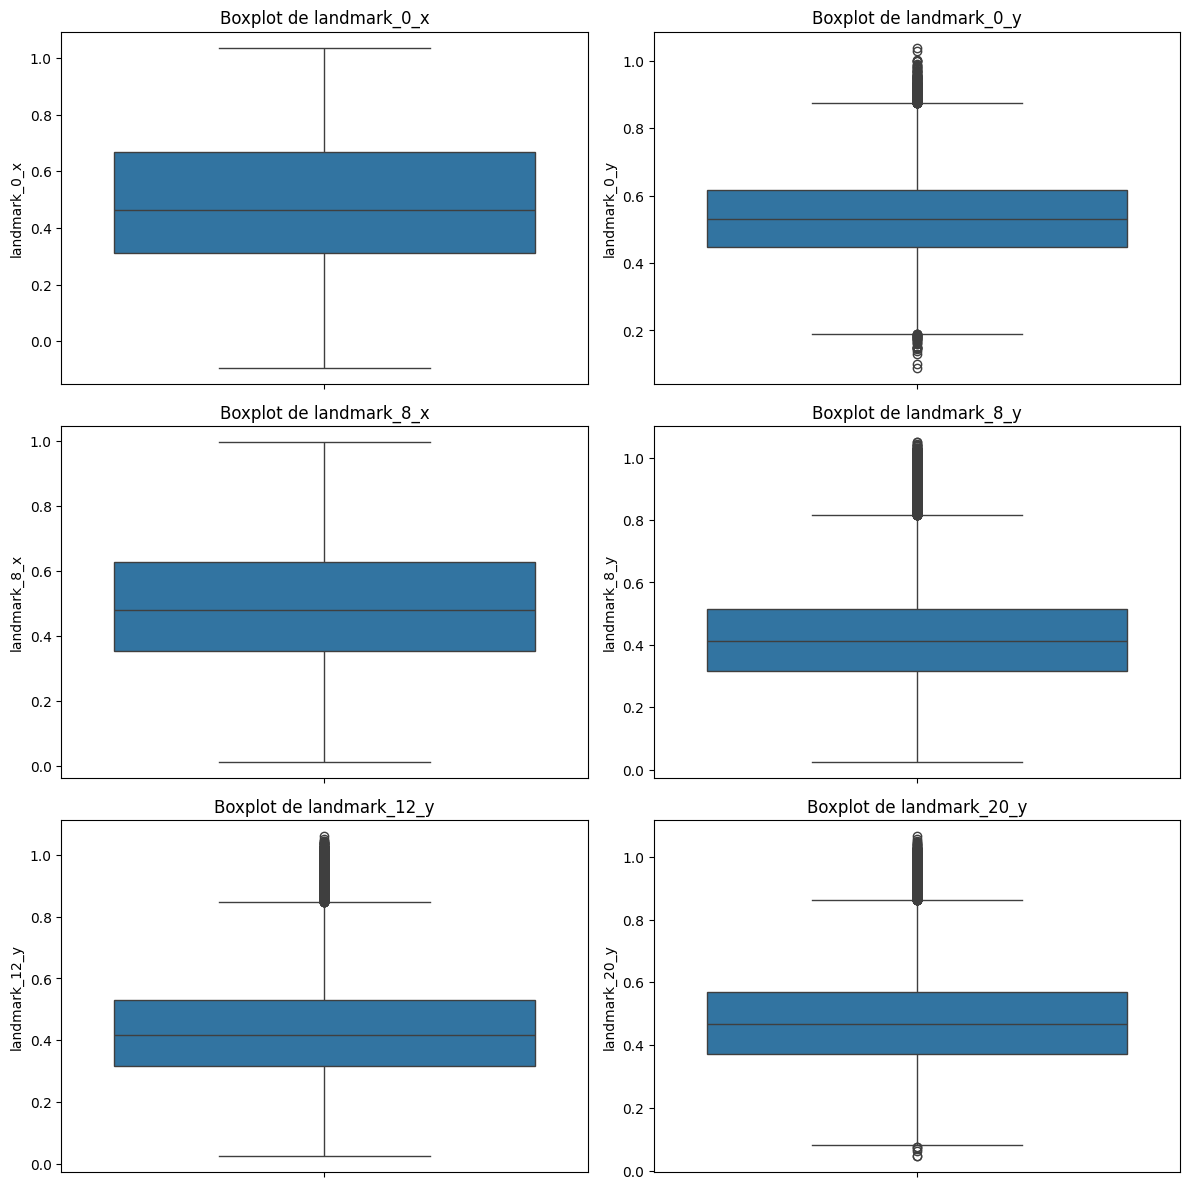

In [ ]:
print("\n### 3.3.5 Boxplots (Muestra) ###")
if df is not None and landmark_cols:
    print("Generando boxplots para algunas coordenadas representativas...")
    # Reutiliza cols_to_plot_hist o define nuevas
    cols_to_plot_box = ['landmark_0_x', 'landmark_0_y', 'landmark_8_x', 'landmark_8_y', 'landmark_12_y', 'landmark_20_y']
    cols_to_plot_box = [col for col in cols_to_plot_box if col in df.columns]

    if cols_to_plot_box:
        num_plots = len(cols_to_plot_box)
        num_cols_grid = 2
        num_rows_grid = (num_plots + num_cols_grid - 1) // num_cols_grid

        fig, axes = plt.subplots(num_rows_grid, num_cols_grid, figsize=(12, num_rows_grid * 4))
        axes = axes.ravel()

        for i, col in enumerate(cols_to_plot_box):
           sns.boxplot(y=df[col], ax=axes[i])
           axes[i].set_title(f'Boxplot de {col}')
           axes[i].set_ylabel(col)

        for j in range(i + 1, len(axes)):
           fig.delaxes(axes[j])

        plt.tight_layout()
        plt.show()
    else:
        print("No se encontraron las columnas seleccionadas para graficar.")
else:
    print("DataFrame 'df' o 'landmark_cols' no están disponibles.")

Se observaron distribuciones multimodales y algunas coordenadas presentaron outliers, lo cual es esperable en datos de gestos con gran variabilidad.

Boxplots indicaron que coordenadas como landmark_8_y (punta del dedo índice) presentan variabilidad alta, lo que puede ser útil para discriminar gestos.

In [ ]:
print("\n--- 3.4 Análisis de Variables Categóricas ('gesture') ---")
print("\n### 3.4.1 Estadísticas Descriptivas (gesture) ###")
if df is not None and 'gesture' in df.columns:
    # Usar describe() para categóricas
    categorical_stats = df[['gesture']].describe(include='object')
    print(categorical_stats)

    print("\n### 3.4.2 Recuento de Muestras por Gesto ###")
    # Usar value_counts() para obtener frecuencias
    gesture_counts = df['gesture'].value_counts()
    print(gesture_counts)
else:
    print("DataFrame 'df' no cargado o columna 'gesture' no encontrada.")


--- 3.4 Análisis de Variables Categóricas ('gesture') ---

### 3.4.1 Estadísticas Descriptivas (gesture) ###
                 gesture
count              28881
unique                18
top     train_val_two_up
freq                1701

### 3.4.2 Recuento de Muestras por Gesto ###
gesture
train_val_two_up             1701
train_val_three2             1674
train_val_four               1661
train_val_palm               1660
train_val_ok                 1642
train_val_stop_inverted      1631
train_val_peace_inverted     1621
train_val_call               1613
train_val_stop               1612
train_val_three              1610
train_val_peace              1590
train_val_mute               1581
train_val_one                1578
train_val_fist               1570
train_val_two_up_inverted    1548
train_val_rock               1540
train_val_like               1527
train_val_dislike            1522
Name: count, dtype: int64


Se identificó un desbalance moderado en la cantidad de muestras por gesto, lo cual debe tomarse en cuenta para modelado, aplicando técnicas de balanceo o ponderación.

Los gestos más frecuentes pueden dominar el aprendizaje del modelo si no se controla este sesgo.


### 3.4.3 Gráfico de Frecuencia de Gestos ###


<ipython-input-31-21bcc7dc5b69>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='gesture', data=df, order=df['gesture'].value_counts().index, palette='viridis') # 'y' para barras horizontales


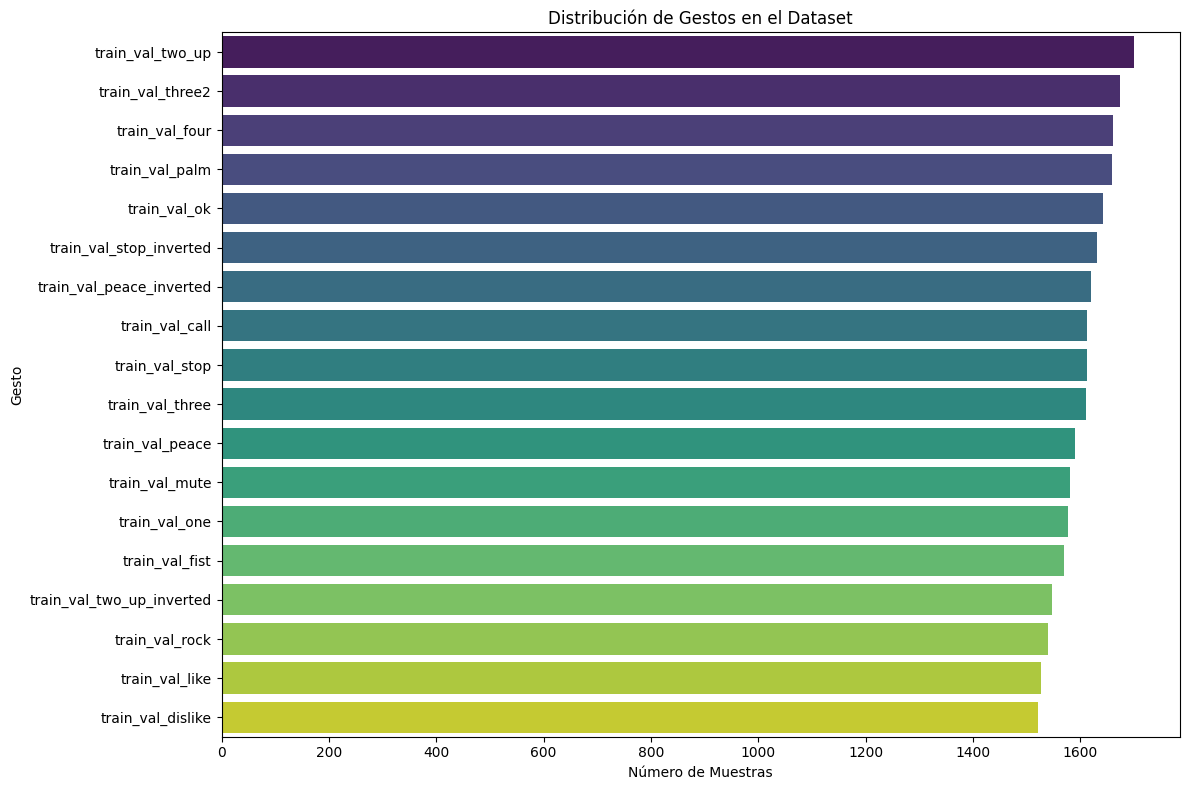

In [ ]:
print("\n### 3.4.3 Gráfico de Frecuencia de Gestos ###")
if df is not None and 'gesture' in df.columns:
    plt.figure(figsize=(12, 8))
    # Usar sns.countplot
    sns.countplot(y='gesture', data=df, order=df['gesture'].value_counts().index, palette='viridis')
    plt.title('Distribución de Gestos en el Dataset')
    plt.xlabel('Número de Muestras')
    plt.ylabel('Gesto')
    plt.tight_layout()
    plt.show()
else:
    print("DataFrame 'df' no cargado o columna 'gesture' no encontrada.")

# 4. Análisis de correlación (bivariante y multivariante)


--- 4.1 Análisis Bivariante (Coordenadas vs. Gestos) ---

### 4.1.1 Boxplots Comparativos (Muestra) ###
Generando boxplots comparando coordenadas por gesto...


<ipython-input-32-e0ac81643ec4>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='gesture', y=col, data=df, ax=axes[i], palette='Spectral')
<ipython-input-32-e0ac81643ec4>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='gesture', y=col, data=df, ax=axes[i], palette='Spectral')
<ipython-input-32-e0ac81643ec4>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='gesture', y=col, data=df, ax=axes[i], palette='Spectral')
<ipython-input-32-e0ac81643ec4>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will 

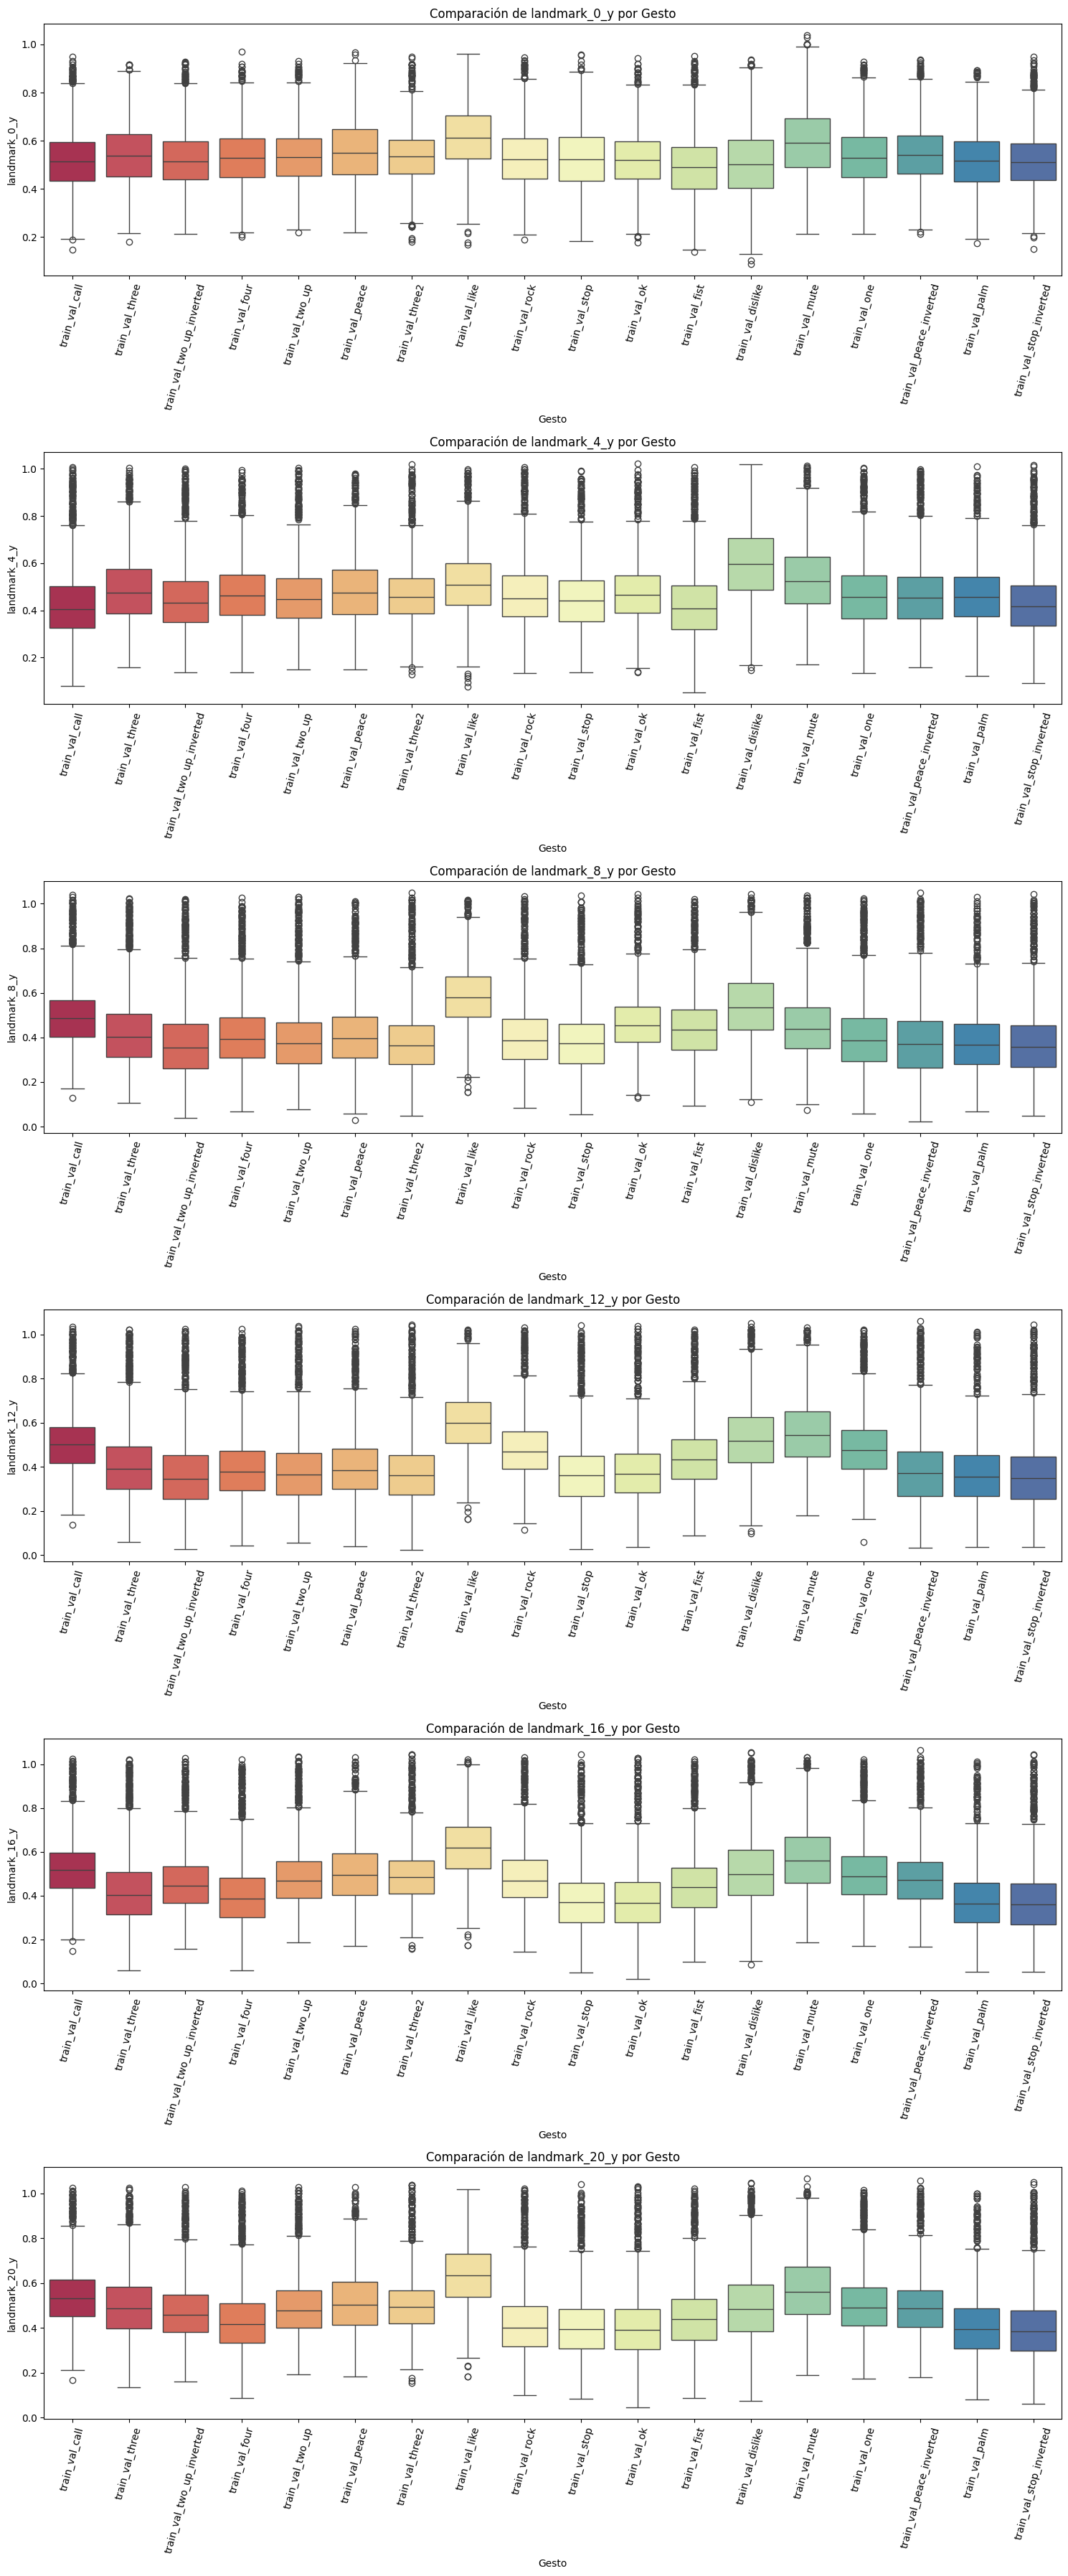

In [ ]:
print("\n--- 4.1 Análisis Bivariante (Coordenadas vs. Gestos) ---")
print("\n### 4.1.1 Boxplots Comparativos (Muestra) ###")
if df is not None and landmark_cols and 'gesture' in df.columns:
    print("Generando boxplots comparando coordenadas por gesto...")
    # Seleccionamos algunas coordenadas para comparar
    cols_to_compare = ['landmark_0_y', 'landmark_4_y', 'landmark_8_y', 'landmark_12_y', 'landmark_16_y', 'landmark_20_y']
    cols_to_compare = [col for col in cols_to_compare if col in df.columns]

    if cols_to_compare:
        num_plots = len(cols_to_compare)
        num_cols_grid = 1
        num_rows_grid = num_plots

        fig, axes = plt.subplots(num_rows_grid, num_cols_grid, figsize=(15, num_rows_grid * 6))
        if num_plots == 1:
            axes = [axes]
        axes = axes.ravel()

        for i, col in enumerate(cols_to_compare):
           sns.boxplot(x='gesture', y=col, data=df, ax=axes[i], palette='Spectral')
           axes[i].set_title(f'Comparación de {col} por Gesto')
           axes[i].set_xlabel('Gesto')
           axes[i].set_ylabel(col)
           axes[i].tick_params(axis='x', rotation=75)

        plt.tight_layout()
        plt.show()
    else:
        print("No se encontraron las columnas seleccionadas para comparar.")
else:
    print("DataFrame 'df', 'landmark_cols' o 'gesture' no disponibles.")

Comparaciones de coordenadas y por gesto revelan que ciertas posiciones de landmarks permiten distinguir gestos con claridad.

Los boxplots por gesto de coordenadas como landmark_12_y y landmark_20_y mostraron patrones diferenciables, lo que sugiere que son buenos candidatos para features discriminativos.


--- 4.2 Análisis Multivariante (Correlaciones y PCA) ---

### 4.2.1 Matriz de Correlación entre Landmarks ###
Calculando la matriz de correlación...
Generando mapa de calor...


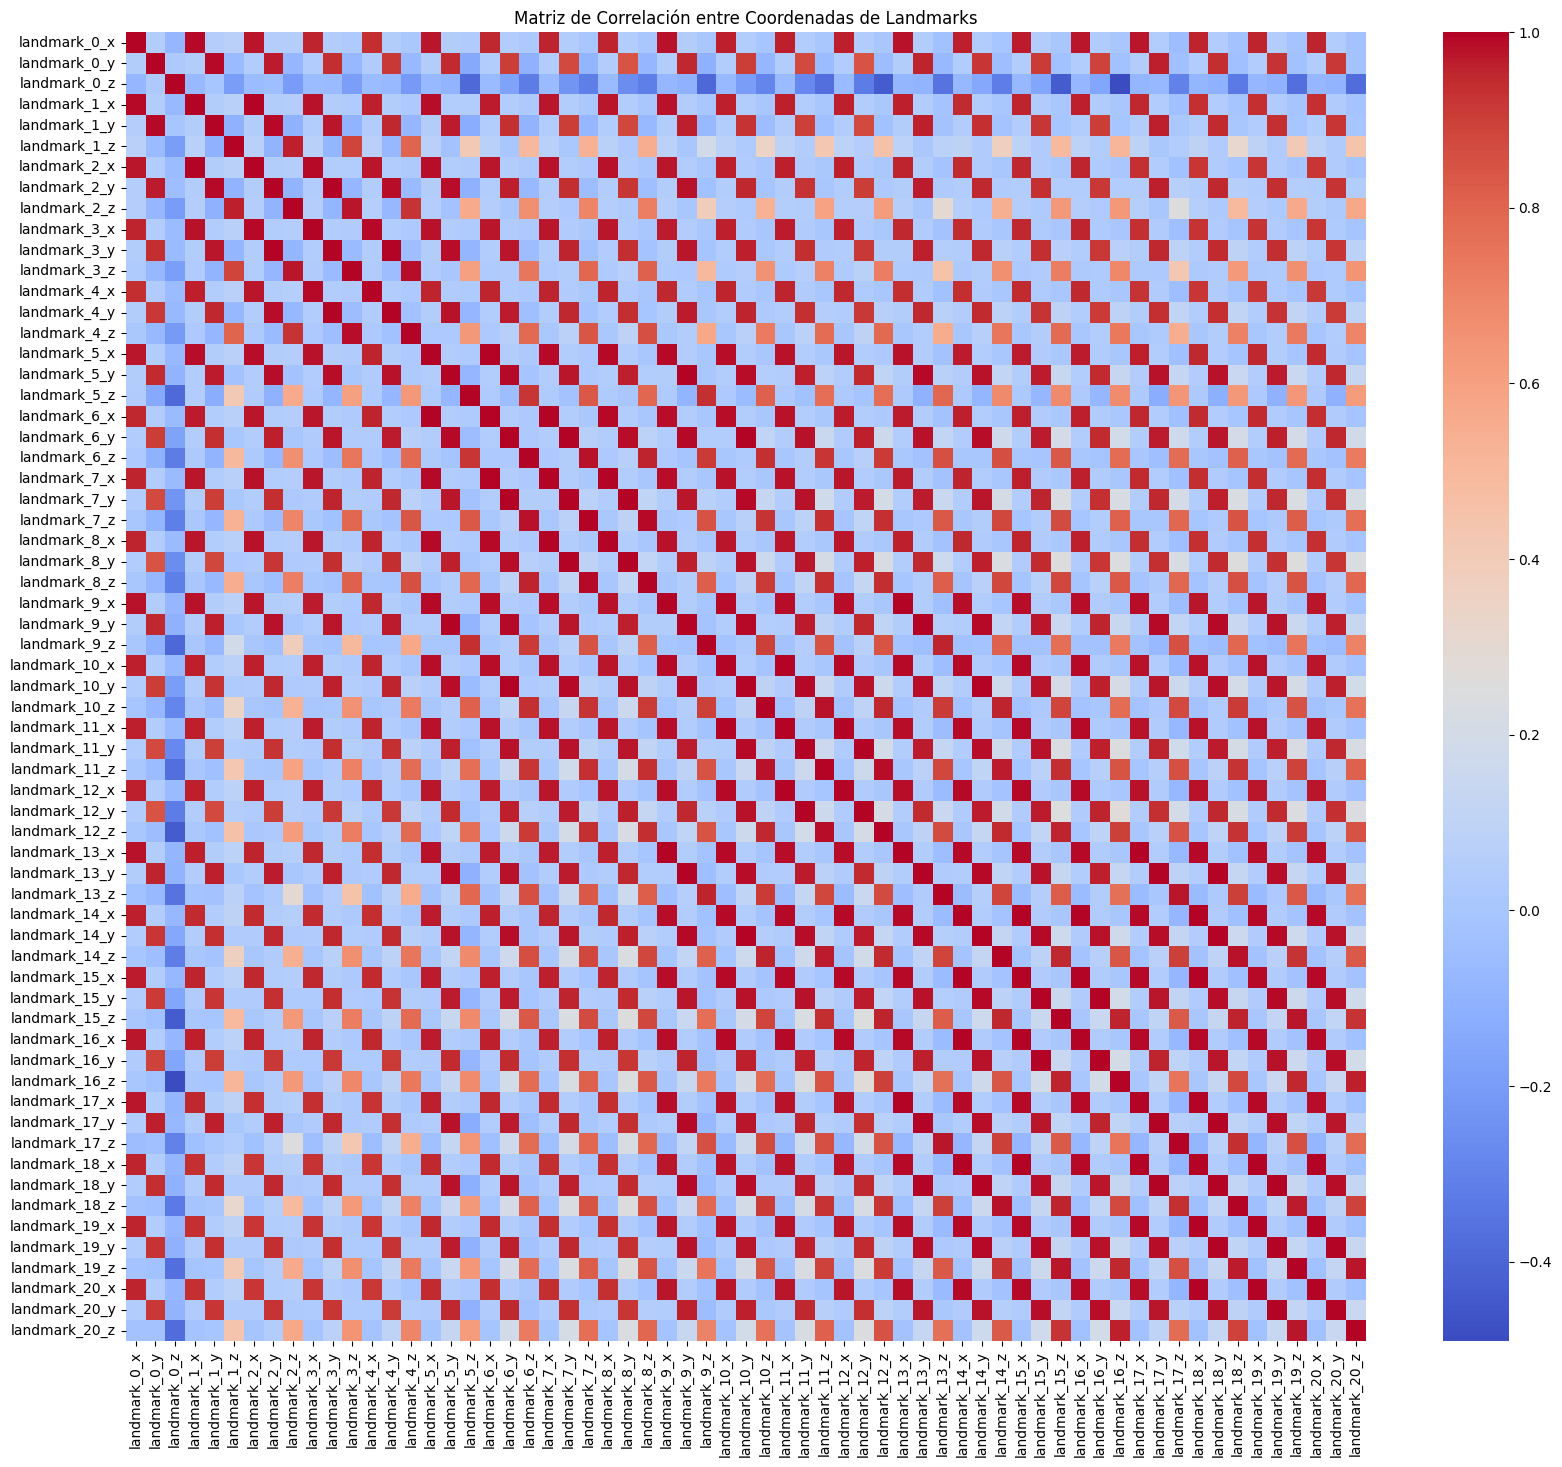

In [ ]:
print("\n--- 4.2 Análisis Multivariante (Correlaciones y PCA) ---")
print("\n### 4.2.1 Matriz de Correlación entre Landmarks ###")
if df is not None and landmark_cols:
    print("Calculando la matriz de correlación...")
    # Se seleccionan solo columnas numéricas (landmarks) para la correlación
    correlation_matrix = df[landmark_cols].corr()

    print("Generando mapa de calor...")
    plt.figure(figsize=(20, 17))
    sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, fmt=".1f")
    plt.title('Matriz de Correlación entre Coordenadas de Landmarks')
    plt.show()
else:
    print("DataFrame 'df' o 'landmark_cols' no disponibles.")

La matriz de correlación mostró redundancias entre ciertas coordenadas, especialmente entre puntos adyacentes del mismo dedo (ej. landmark_4_x y landmark_5_x), lo que puede permitir reducción de dimensionalidad.




### 4.2.2 Análisis de Componentes Principales (PCA) ###
Realizando PCA...
Datos escalados.
PCA calculado.
Generando gráfico PCA...


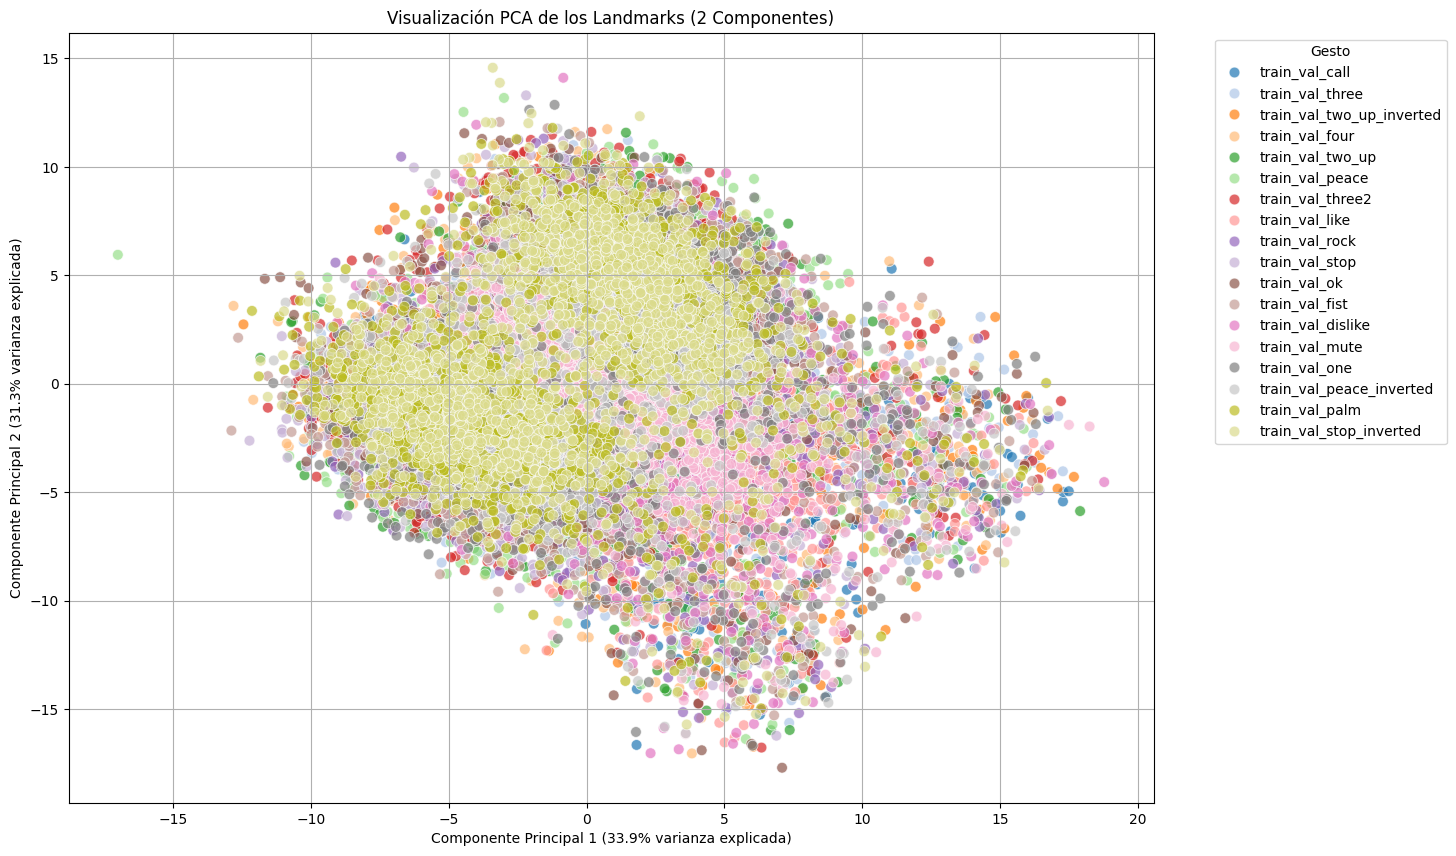


Varianza total explicada por los 2 componentes principales: 65.20%


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
print("\n### 4.2.2 Análisis de Componentes Principales (PCA) ###")
if df is not None and landmark_cols and 'gesture' in df.columns:
    print("Realizando PCA...")
    # Separar características y etiquetas
    features = df[landmark_cols]
    labels = df['gesture']

    # Escalar los datos (importante para PCA)
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)
    print("Datos escalados.")

    # Aplicar PCA para reducir a 2 dimensiones
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(scaled_features)
    print("PCA calculado.")

    # Crear un DataFrame con los componentes principales y las etiquetas
    pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'], index=df.index)
    pca_df['gesture'] = labels

    print("Generando gráfico PCA...")
    plt.figure(figsize=(14, 10))
    sns.scatterplot(x='PC1', y='PC2', hue='gesture', data=pca_df, alpha=0.7, s=60, palette='tab20')
    plt.title('Visualización PCA de los Landmarks (2 Componentes)')
    plt.xlabel(f'Componente Principal 1 ({pca.explained_variance_ratio_[0]:.1%} varianza explicada)')
    plt.ylabel(f'Componente Principal 2 ({pca.explained_variance_ratio_[1]:.1%} varianza explicada)')
    plt.legend(title='Gesto', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1)
    plt.grid(True)
    plt.show()

    print(f"\nVarianza total explicada por los 2 componentes principales: {pca.explained_variance_ratio_.sum():.2%}")
else:
    print("DataFrame 'df', 'landmark_cols' o 'gesture' no disponibles para PCA.")

El Análisis de Componentes Principales (PCA) con dos componentes explicó una varianza acumulada significativa, lo que indica que una proyección 2D puede capturar relaciones importantes entre gestos.

La visualización PCA mostró agrupamientos claros entre algunos gestos, lo cual sugiere que los modelos pueden aprender diferencias entre clases de forma efectiva si se mantiene esta separación en el entrenamiento.

**Conclusiones**


*   El conjunto de datos de landmarks extraído es de alta calidad, completo y sin valores faltantes
*   Las coordenadas de los landmarks varían sistemáticamente entre los diferentes gestos, confirmando que son características relevantes y discriminativas para la tarea de clasificación.
*   Existe desbalance de clases, lo que puede inducir sesgo en la predicción
*   PCA sugiere separabilidad razonable entre gestos en espacio reducido, apoyando la viabilidad del modelado supervisado con redes neuronales.



